<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **(Urclass Quiz) 다음 조건에서 F beta score를 구하고 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다.

일단 다운받기

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c prediction-of-h1n1-vaccination

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd

target = 'vacc_h1n1_f'

train = pd.merge(pd.read_csv('/content/train.csv.zip'), 
                 pd.read_csv('/content/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('/content/test.csv.zip')

In [6]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

F beta score

In [7]:
TP = 4442
TN = 6165
FP = 1515
FN = 1930

def fbeta_score(precision, recall, beta = 1.0):
  return (1.0 + (beta ** 2)) * (precision * recall) / (((beta **2) * precision) + recall)

precision = TP / (TP + FN)
recall = TP / (TP + FP)
beta = 2.0

print('f beta score:', fbeta_score(precision, recall, beta))

f beta score: 0.7354304635761588


### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(Urclass Quiz) 임계값을 증가시킬때 positive 범주의 재현율 변화 중 올바른 설명을 고르세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


In [8]:
def engeneer(df):
    # 높은 카디널리티를 가지는 특성을 제거
    selected_cols = df.select_dtypes(include = ['number', 'object'])
    labels = selected_cols.nunique()
    selected_feature = labels[labels <= 25].index.tolist()
    df = df[selected_feature]

    dels = [col for col in df.columns if ('seas' in col or 'seasonal' in col)] # seas 포함하는 컬럼 제거
    df.drop(columns = dels, inplace = True)

    return df

In [11]:
train = engeneer(train)
val = engeneer(val)
test = engeneer(test)

In [12]:
features = train.drop(columns = [target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [15]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=10, n_jobs=-1, n_estimators = 100, oob_score=True))

pipe.fit(X_train, y_train)
print('검증 정확도', pipe.score(X_val, y_val))

검증 정확도 0.8193571343850077


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


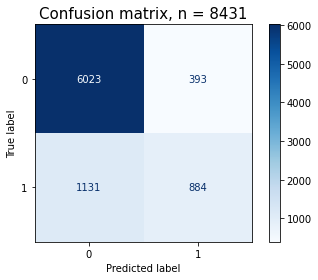

In [16]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
cm = pcm.confusion_matrix
cm

array([[6023,  393],
       [1131,  884]])

In [18]:
y_pred = pipe.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[6023,  393],
       [1130,  885]])

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      6416
           1       0.69      0.44      0.54      2015

    accuracy                           0.82      8431
   macro avg       0.77      0.69      0.71      8431
weighted avg       0.81      0.82      0.80      8431



In [20]:
y_pred_proba = pipe.predict_proba(X_val)[:,1]
y_pred_proba

array([0.08716667, 0.08      , 0.56      , ..., 0.22      , 0.1       ,
       0.37      ])

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

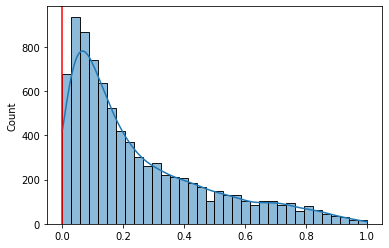

In [21]:
from ipywidgets import interact, fixed
import seaborn as sns
from sklearn.metrics import classification_report

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


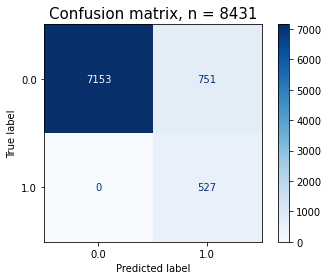

In [24]:
threshold = 0.7
y_pred = (pipe.predict_proba(X_val)[:, 1] > threshold).astype('float')

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_pred,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_pred)}', fontsize=15)
plt.show()

In [25]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      6416
           1       0.81      0.21      0.34      2015

    accuracy                           0.80      8431
   macro avg       0.81      0.60      0.61      8431
weighted avg       0.80      0.80      0.75      8431



### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 하이퍼파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, oob_score=True
- **(Urclass Quiz) 확률값들의 분포의 변화를 아래 보기 중에서 고르세요**
    1. 다양해진다
    2. 변화가없다


In [ ]:
### 이곳에서 과제를 진행해 주세요 ###

### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **(Urclass Quiz) 캐글 Leaderboard의 본인 Score를 제출하세요.**

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 

## 🔥 도전과제(Github - Discussion)

### 5) confusion matrix, classification report 등을 그려 보시고, 각 평가지표들에 대해 최대한 분석하고 precision과 recall 중 어느 것을 높이는 방향으로 모델링 해야할지 논의해 보세요. 

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 